In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{row['# of stores']}/{row['Architecture Class']}/{underage_cost}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 4096
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each number of stores
    df['cost'] = df.groupby('# of stores')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="# of stores", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each # of stores)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = df['# of stores'].unique()
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Number of stores')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


   # of stores   Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  # of runs
0            3       Symmetry_Aware    5.613299  5.618869   5.611474    0.031999          9
0            3               GNN_MP    5.614764  5.616858   5.609679    0.000000          9
0            3  GNN_MP_NN_Per_Layer    5.618666  5.620026   5.612805    0.055725          7
1           50       Symmetry_Aware    5.358767  5.356499   5.356091    0.044219          9
1           50               GNN_MP    5.360784  5.356896   5.353724    0.000000          6
1           50  GNN_MP_NN_Per_Layer    5.383069  5.379156   5.375815    0.412623          4


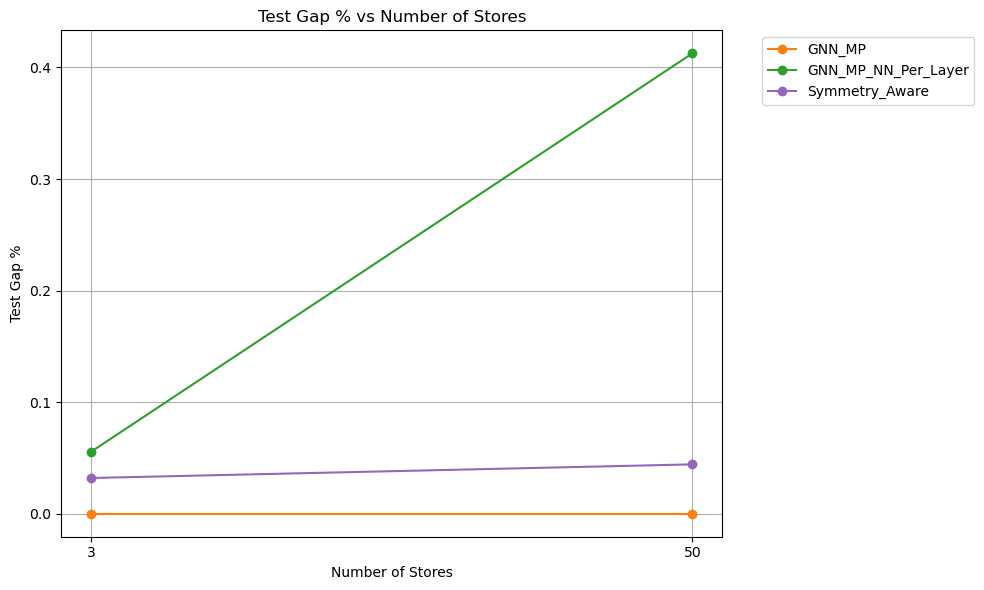

In [6]:
# Define color scheme for architecture types
color_scheme = {
    "Symmetry_Aware": "#9467bd",  # Purple
    "GNN_MP": "#ff7f0e",  # Orange
    "GNN_MP_NN_Per_Layer": "#2ca02c",  # Green
}

linestyle_scheme = {
    "Symmetry_Aware": "-",  # Solid
    "GNN_MP": "-",  # Solid
    "GNN_MP_NN_Per_Layer": "-",  # Solid
}

testset_name = "generic_architecture"
symmetry_aware_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/50'
}
gnn_mp_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/3', 
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/50'
}
gnn_mp_nn_per_layer_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_Per_Layer/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_Per_Layer/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()

# Symmetry aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {'store_orders_for_warehouse': False, 'omit_context_from_store_input': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "Symmetry_Aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

# GNN MP NN Per Layer
df_gnn_mp_nn_per_layer = results_interpretor.make_table(gnn_mp_nn_per_layer_paths,
    {},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_nn_per_layer.insert(2, 'Architecture Class', "GNN_MP_NN_Per_Layer")
df_gnn_mp_nn_per_layer.insert(1, 'hyperparam_name', "GNN_MP_NN_Per_Layer")

# Combine dataframes
df = pd.concat([
    df_symmetry_aware,
    df_gnn_mp,
    df_gnn_mp_nn_per_layer
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
columns_to_drop = ['path', 'Learning Rate', 'include_context_for_warehouse_input', 'hyperparam_name', 'store_orders_for_warehouse', 'omit_context_from_store_input']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].mean().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_exp_underage_cost_random_yield", 1)